<a href="https://colab.research.google.com/github/alessandronicolini/IncrementalLearning/blob/main/mnemonics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install 'import_ipynb'
!pip3 install 'tqdm'
 
!rm -r IncrementalLearning
# upload work files from your git hub repository
import sys
 
!git clone https://github.com/alessandronicolini/IncrementalLearning.git # clone proj repository
!rm -rf IncrementalLearning/README.md 
!rm -rf IncrementalLearning/baselines.ipynb
 
path = 'IncrementalLearning/'
if path not in sys.path:
    sys.path.append('IncrementalLearning/')
 
!pip3 install import_ipynb

Cloning into 'IncrementalLearning'...
remote: Enumerating objects: 66, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 733 (delta 34), reused 0 (delta 0), pack-reused 667
Receiving objects: 100% (733/733), 2.36 MiB | 12.20 MiB/s, done.
Resolving deltas: 100% (435/435), done.


In [2]:
import numpy as np
import torch
from torchvision import transforms
from torchvision.datasets import VisionDataset
from PIL import Image
import random
import torchvision
ROOT = './data'
class ilCIFAR100(VisionDataset):
    """
    Extends CIFAR100 class. Split the dataset into 10 batches, each one containing 10 classes.
    You can retrieve the batches from the attribute "batches", it has different structure according to
    test and train CIFAR100 splits:
        - train -> batches is a dictionary {0:{'train':indexes, 'val':indexes}...} 
        - test -> batches is a dictionary {0:indexes...}
    where the keys are the batch number.
 
    Args:
        root (string): Root directory of dataset where directory
            `cifar-10-batches-py` exists or will be saved to if download is set to True.
        seed(int): used to ensure reproducibility in shuffling operations.
        val_size(float, optional): between 0 and 1, fraction of data used for validation.
        train (bool, optional): If True, creates dataset from training set, otherwise
            creates from test set.
        transform (callable, optional): A function/transform that takes in an PIL image
            and returns a transformed version. E.g, `transforms.RandomCrop`
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
    """
    def __init__(self,classes_per_batch, seed, val_size=0.1, train='train', transform=None, target_transform=False, 
    download=True):
        
        super(ilCIFAR100, self).__init__(root=0)
        self.classes_per_batch=classes_per_batch
 
        
        self.__rs = seed # set random seed 
        self.train = train
        self._transform_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
        ])
 
        self._transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
        ])
        # if train:
        #     self.batches = self.__make_train_batches(val_size)
        # else:
        #     self.batches = self.__make_test_batches()
        if self.train == 'train':
          self.dataset = torchvision.datasets.CIFAR100(root=ROOT, train=True,
                                            download=True, transform=self._transform_train)
        elif self.train == 'exemplars':
          self.dataset = torchvision.datasets.CIFAR100(root=ROOT, train=True,
                                            download=True, transform=self._transform_test)
        else:
          self.dataset = torchvision.datasets.CIFAR100(root=ROOT, train=False,
                                        download=True, transform=self._transform_test)
          
        self.targets = np.array(self.dataset.targets) # make targets an array to exploit masking
        random.seed(seed)
        self.classes = random.sample(range(0, 100), 100)
        #self.classes = self.classes.reshape((10, -1)) # each row contains the classes for the corrisponding batch
        #print(self.classes)
        self.__dictionary = {}
        for i, c in enumerate(self.classes):
          self.__dictionary[c] = i
 
 
    def get_dict(self):
      return self.__dictionary
      
    def __getitem__(self, index):
        return index,self.dataset.__getitem__(index)[0],self.dataset.__getitem__(index)[1]

    def __len__(self):
        return self.dataset.__len__()

    def getbatches(self):
      classlist=self.classes
      batches=[]
      for i in range(0,int(100/self.classes_per_batch)):
        #print(i)
        batch=classlist[int(i*self.classes_per_batch):int(i*10+self.classes_per_batch)]
        batches.append(batch)
      return batches

    def get_batch_indexes(self):
      classlist=self.classes
      numclass=self.classes_per_batch
      batch_indexes=[]
      for i in range(0,int(100/self.classes_per_batch)):
        batch=classlist[int(i*numclass):int(i*numclass+numclass)]
        mask=np.isin(self.targets,batch)
        indexes=np.array(np.arange(len(self.dataset.targets)))
        indexes=indexes[mask]
        batch_indexes.append(indexes)
      return batch_indexes

    def get_class_indexes(self,label):
      indexes = np.array(np.arange(len(self.dataset.targets)))
      labels = self.dataset.targets
      mask = np.isin(labels, label)
      indexes = indexes[mask]
 
      return indexes
    def get_train_val(self,valid):
      batches=self.get_batch_indexes()
      train=[]
      val=[]
      for batch in batches:
        #print(type(batch))
        random.shuffle(batch)
        valbatch=batch[0:int(valid*len(batch))]
        trainbatch=batch[int(valid*len(batch)):]
        train.append(trainbatch)
        val.append(valbatch)
      return train,val

In [3]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
from PIL import Image
import torchvision
import torchvision.transforms as transforms
import math
from sklearn.preprocessing import normalize
import copy
import torchvision.datasets as dsets
import torchvision.models as models
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from torch.utils.data import Subset, DataLoader, Dataset
import random
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import pandas as pd
from sklearn.manifold import TSNE
import import_ipynb
import sklearn
#from IncrementalLearning.cifar100 import ilCIFAR100

from IncrementalLearning.resnet_cifar import resnet32
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

importing Jupyter notebook from /content/IncrementalLearning/resnet_cifar.ipynb


In [4]:
# SOME UTILS FUNCTIONS

def tensor2im(input_image, imtype=np.uint8):
    mean = [0.5071, 0.4867, 0.4408]
    std = [0.2675, 0.2565, 0.2761]
    if not isinstance(input_image, np.ndarray):
        if isinstance(input_image, torch.Tensor):
            image_tensor = input_image.data
        else:
            return input_image
        image_numpy = image_tensor.cpu().detach().float().numpy()
        if image_numpy.shape[0] == 1:
            image_numpy = np.tile(image_numpy, (3, 1, 1))
        for i in range(len(mean)): 
            image_numpy[i] = image_numpy[i] * std[i] + mean[i]
        image_numpy = image_numpy * 255
        image_numpy = np.transpose(image_numpy, (1, 2, 0))
    else:
        image_numpy = input_image
    return image_numpy.astype(imtype)



In [5]:
class mnemonics():
  def __init__(self, randomseed, name):
    self.device = 'cuda'
    self.model = resnet32(num_classes=100).to(self.device)
    self.temp_model = None
    self.lr = 2# 2 before
    self.gamma = 0.2
    self.weight_decay = 1e-5 
    self.milestones = [49,63]
    self.batch_size = 128
    self.numepochs = 70
    self.n_classes = 0
    self.n_known = 0
    self.feature_size = 64
    self.momentum = 0.9
    self.criterion = nn.BCEWithLogitsLoss()

    self.NUM_BATCHES=10
    self.randomseed=randomseed
    self.name = name+"_"+str(randomseed)
    self.model_level_loader=None
    self.testloader=None
    self.CLASSES_PER_BATCH=10
    self.original_training_set = ilCIFAR100(self.CLASSES_PER_BATCH,self.randomseed, train='train')
    self.original_exemplar_set = ilCIFAR100(self.CLASSES_PER_BATCH,self.randomseed, train='exemplars')
    self.original_test_set = ilCIFAR100(self.CLASSES_PER_BATCH,self.randomseed, train='test')
    
    self.last_test = None
    self.y_pred = []
    self.y_test = []

    self.classes_seen=0
    self.diz = self.original_training_set.get_dict()

    self.exemplar_features_mean = None

    # lista di liste, ogni lista contiene gli exemplars di una classe
    self.exemplar_sets_idxs = [] 

    # tsne attributes
    tsne_train_idxs = []
    colors = ['#0b649e', '#d85c20','#c43509', '#21130d','#741a00']
    for label in self.original_training_set.getbatches()[0][:5]:
      tsne_train_idxs.append(self.original_training_set.get_class_indexes(label).tolist())

    self.tsne_train_idxs = tsne_train_idxs
    self.color_dict = {label:color for label, color in zip(self.original_training_set.getbatches()[0][:5], colors)}

    # distances between exemplar classes and real distribution
    self.distances = []
  
  def finetuning(self, net, train_idxs, batch_size, epochs, optimizer, scheduler):
    # il lr iniale deve essere basso !!!
    # freeze all the layers unless the last one (we have 8 layers)
    for layer in list(self.model.children())[:7]:
      for p in layer.parameters():
        p.requires_grad=False
    
    unlocked_layer = 8

    # crea il training dataset
    train_dataset = Subset(self.original_exemplar_set, train_idxs) # prendi le immagini senza data augmentation
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
    criterion = nn.BCEWithLogitsLoss()

    # traina per 16 epoche, ogni due epoche sblocca un layer in modo da averli 
    # gradualmente sbloccati tutti per quando si arriva alla fine
    for epoch in range(epochs):

      # controlla se devi sbloccare il layer
      """if (epoch+1)%2 == 0:
        unlocked_layer -= 1
        for p in list(self.model.children())[unlocked_layer].parameters():
          p.requires_grad=True"""
        
      
      # esegui l'epoca di training
      for _, inputs, labels in train_loader:
        inputs = inputs.cuda()
        labels = torch.tensor([self.diz[c.item()] for c in labels])
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = net(inputs)
        labels_encoded = F.one_hot(labels,100).float().cuda()
        loss = criterion(outputs, labels_encoded)
        loss.backward()
        optimizer.step()
      
      scheduler.step()

  def update_params(self, 
                    m,
                    finetuning_idxs, 
                    training_idxs, 
                    mnemonics_to_optimize, 
                    batch_size,
                    task_num,
                    new=True,
                    lr=0.01, 
                    momentum=0.9, 
                    weight_decay=1e-5, 
                    step=10,
                    gamma=0.5, 
                    tuning_epochs=2,
                    updating_epochs=20):
    
    """
    finetuning_idxs = indexes of current task elements
    mnemonics_idxs = indexes of exemplar elements
    mnemonics_to_optimize = the optimized parameters in the update phase
    """

    # make a copy of the model
    model_copy = copy.deepcopy(self.model)
    model_copy.train()
    model_copy.to(self.device)

    # define the loss
    # criterion = nn.BCEWithLogitsLoss()

    # FINE TUNING FOR 1 EPOCH eq. 8 --------------------------------------------
    
    # define optimizer and scheduler for fine tuning phase
    optimizer = optim.SGD(model_copy.parameters(), lr=0.001, momentum=momentum, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)

    # now fine tune the copied model
    
    ft_options = {
        'net': model_copy,
        'train_idxs': finetuning_idxs,
        'batch_size': batch_size,
        'epochs': 16,
        'optimizer': optimizer,
        'scheduler': scheduler
    }
    self.finetuning(**ft_options)

    # UPDATE THE MNEMONICS eq.9/10 ---------------------------------------------
    
    model_copy.eval()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(mnemonics_to_optimize, lr=0.1, momentum=momentum, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step, gamma=gamma)

    if new:
      exlvl_training = Subset(self.original_training_set, training_idxs)
      exlvl_loader = DataLoader(exlvl_training, batch_size=batch_size, shuffle=True, num_workers=4)
      new_dict = {label:new_label for new_label, label in enumerate(self.original_training_set.getbatches()[task_num])}
    else:
      exlvl_training = Subset(self.original_exemplar_set, training_idxs)
      exlvl_loader = DataLoader(exlvl_training, batch_size=batch_size, shuffle=True, num_workers=4)
    
    #print('lunghezza del exemplar update:', len(training_idxs))
    for epoch in tqdm(range(updating_epochs)):
      epoch_loss = 0
      count_elements = 0
      for _, inputs, labels in exlvl_loader:
        count_elements += len(inputs)
        labels = torch.tensor([new_dict[c.item()] for c in labels]).to(self.device)
        inputs = inputs.to(self.device)
        optimizer.zero_grad()
        out_features = model_copy.features(inputs)
        n_classes = int(len(finetuning_idxs)/m)
        all_class_means = torch.zeros((0, 64))
        all_class_means = all_class_means.to(self.device)
        for i in range(n_classes): # how many classes
          #print(mnemonics_to_optimize[i].is_leaf)
          #print(mnemonics_to_optimize[i].requires_grad)
          mnemonics_features = model_copy.features(mnemonics_to_optimize[i]) # sahpe m, 64
          #menmonics_features = F.normalize(mnemonics_features)
          this_class_means = torch.mean(mnemonics_features, dim=0) # size 64
          this_class_means = torch.unsqueeze(this_class_means, dim=0) # add the second dimension
          all_class_means = torch.cat((all_class_means, this_class_means), dim=0)
        the_logits = F.linear(out_features,all_class_means)

        
        #labels_encoded = F.one_hot(labels,100).float().cuda()
        #print(the_logits)
        loss = criterion(the_logits, labels) # al secondo batch di classi per i new mnemonics le uscite sono sempre 10 ma le label vanno da 10 a 19
        epoch_loss += loss.item()*len(inputs)
        loss.backward()
        # print(mnemonics_to_optimize[0].grad)
        optimizer.step()
      scheduler.step()
      print('epoch loss %.2d: %.3f'%(epoch+1, epoch_loss/count_elements))


  def exemplar_level_optimization(self, m, task_num, current_task_indices, last_finetuning_epochs=2):  
    
    # UPDATING NEW EXEMPLAR-----------------------------------------------------
    # trova tutti gli indici dei nuovi exemplars
    new_exemplar_idxs = []

    new_mnemonics_data_list = []
    for i, idxs in enumerate(self.exemplar_sets_idxs[-10:]):
      new_exemplar_idxs += idxs
      new_mnemonics_data = torch.zeros((m, 3, 32, 32))
      for j, idx in enumerate(idxs):
        new_mnemonics_data[j, :, :, :] = self.original_exemplar_set.__getitem__(int(idx))[1]
      new_mnemonics_data_list.append(new_mnemonics_data)
      
    print(new_mnemonics_data[0].is_leaf)
    new_mnemonics = [mne_data.clone().float().to(self.device).requires_grad_() for mne_data in new_mnemonics_data_list]
    
    print(new_mnemonics[0].is_leaf)
    print(new_mnemonics[0].size())
    print(new_mnemonics[0].dtype)

    options_new ={'finetuning_idxs': new_exemplar_idxs, 
                  'training_idxs': current_task_indices, 
                  'mnemonics_to_optimize':  new_mnemonics,  
                  'batch_size':128,
                  'm':m,
                  'task_num':task_num}

    print('---start new mnemonics updating---')

    self.update_params(**options_new)    

    for i, idxs in enumerate(self.exemplar_sets_idxs[-10:]):
      for j, idx in enumerate(idxs):
        self.original_exemplar_set.dataset.data[idx] = tensor2im(new_mnemonics[i][j])

    # LAST FINETUNING    
    optimizer = optim.SGD(self.model.parameters(), 
                          lr=0.001, 
                          momentum=self.momentum, 
                          weight_decay=self.weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)
    
    all_exemplar_idxs = []
    for exemplar_idxs in self.exemplar_sets_idxs:
      all_exemplar_idxs += exemplar_idxs

    self.model.train()
    
    ft_options = {
        'net': self.model,
        'train_idxs':all_exemplar_idxs,
        'batch_size': 64,
        'epochs': last_finetuning_epochs,
        'scheduler': scheduler,
        'optimizer': optimizer
    }
    self.finetuning(**ft_options)
    self.model.eval()
      

  def model_level_optimization(self, iteration):
    
    old_model = copy.deepcopy(self.model)
    old_model.eval()
    old_model.to(self.device)
    n_classes = self.classes_seen+self.CLASSES_PER_BATCH
    print(n_classes)
    optimizer = optim.SGD(self.model.parameters(), lr=self.lr, momentum=self.momentum, weight_decay=self.weight_decay)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=self.milestones, gamma=self.gamma)
    
    for epoch in tqdm(range(self.numepochs)): 
      for _, inputs, labels in self.model_level_loader:
        inputs = inputs.float().to(self.device)
        labels = torch.tensor([self.diz[c.item()] for c in labels])

        labels=labels.to(self.device)
        optimizer.zero_grad()
        outputs=self.model(inputs)

        labels_encoded = F.one_hot(labels,100).float().to(self.device) #CAMBIARE ONE_HOT
        
        if self.classes_seen:
          old_target = old_model(inputs).to(self.device)
          old_target = torch.sigmoid(old_target).to(self.device)
          
          target = torch.cat((old_target[:,:self.classes_seen], labels_encoded[:, self.classes_seen:]), dim=1)
          loss = self.criterion(outputs, target)
        else:
          loss = self.criterion(outputs, labels_encoded) 

        loss.backward()
        optimizer.step()
      
      scheduler.step()
    
    torch.save(self.model.state_dict(), 'resnet_task_'+str(iteration))


  def classify_nme(self, input_batch):
    min_distances = float('inf')*torch.ones(len(input_batch)).to(self.device) # shape: batch_size --> 128
    y_pred = torch.zeros(len(input_batch), dtype=torch.int8).to(self.device) # shape: batch_size --> 128
    input_features = self.model.features(input_batch) # shape: (batch_size, feature_size) --> (128, 64)

    for i in range(len(self.exemplar_sets_idxs)):
      ex_mean = self.exemplar_means[i,:]

      # compute distances between inputs features and exemplar set means
      pdist = nn.PairwiseDistance(p=2)
      distances = pdist(input_features, ex_mean) # shape: batch_size --> 128

      # update min distancies and predicted labels
      mask = distances < min_distances
      min_distances[mask] = distances[mask]
      y_pred[mask] = self.exemplar_labels[i]

    return y_pred


  def get_new_exemplars(self, batch, m):
    self.exemplar_sets_idxs.append(random.sample(list(batch), m))
    """loader = torch.utils.data.DataLoader(batch, batch_size=self.batch_size,shuffle=False, num_workers=4)
    features = np.zeros((0,self.feature_size))
    indices = np.zeros((0), dtype=int)
    with torch.no_grad():
      for indexes, images, labels in loader:
        images = images.cuda()
        feature = self.model.features(images).data.cpu().numpy()
        feature = normalize(feature, axis=1, norm='l2')
        features = np.concatenate((features,feature), axis=0)
        indices = np.concatenate((indices,indexes), axis=0)

    class_mean = np.mean(features, axis=0)
    class_mean = class_mean / np.linalg.norm(class_mean)  # Normalize

    exemplar_set = []
    exemplar_features = np.zeros((0,self.feature_size))

    for k in range(1, int(m)+1):
        S = np.sum(exemplar_features, axis=0)
        phi = features
        mu = class_mean
        mu_p = 1.0 / k * (phi + S)
        mu_p = normalize(mu_p, axis=1, norm='l2')
        i = np.argmin(np.sqrt(np.sum((mu - mu_p) ** 2, axis=1)))
        exemplar_set.append(indices[i])
        addfeature =  np.expand_dims(features[i], axis=0)
        exemplar_features = np.concatenate((exemplar_features,addfeature), axis=0)

        #remove duplicates
        features = np.delete(features, i, 0)
        indices = np.delete(indices, i, 0)
        
    self.exemplar_sets_idxs.append(exemplar_set)"""

  def reduce_old_exemplars(self, m):
    for i, set_i in enumerate(self.exemplar_sets_idxs):
      self.exemplar_sets_idxs[i] = set_i[:m]


  def __accuracy_fc(self, dl, mapper):
    total = 0.0
    correct = 0.0
    for  _, images, labels in dl:
      labels = torch.tensor([torch.tensor(mapper[c.item()]) for c in labels])
      labels = labels.to(self.device)
      images = images.to(self.device)
      outputs = self.model(images)
      _, preds = torch.max(outputs, dim=1)
      total += len(labels)
      correct += torch.sum(preds == labels).item()

    acc = correct / total
    return acc


  def __accuracy_nme(self, dl):
    
    total = 0.0
    correct = 0.0
    
    for  _, images, labels in dl:
      labels = labels.to(self.device)
      images = images.to(self.device)
      preds = self.classify_nme(images)
      total += len(labels)
      correct += torch.sum(preds == labels).item()

      if self.last_test:
        self.y_pred += preds.tolist()
        self.y_test += labels.tolist()

    acc = correct / total
    return acc


  def plot_confusion_matrix(self):
 
    cm = confusion_matrix(self.y_test, self.y_pred)
    cm = np.log(cm+1)
    fig, ax = plt.subplots(figsize=(7,7))
    sns.heatmap(cm, square=True, cbar=False, ax=ax, cmap=plt.get_cmap('seismic'))
    ax.set_xticks(np.linspace(19,99,5))
    ax.set_yticks(np.linspace(19,99,5))
    ax.set_xticklabels([20,40,60,80,100], rotation=0)
    ax.set_yticklabels([20,40,60,80,100], rotation=0)
    ax.set_title("iCaRL")
    ax.set_xlabel("Predicted class")
    ax.set_ylabel("True class")
    plt.savefig("iCaRL_"+str(self.randomseed)+"_cm.png")
    plt.show()
    return cm

  def add_tsne_plot(self, task_num):

    # salva l'attuale transform e inseriscine uno nuovo che non faccia data augmentation
    transform = self.original_training_set.dataset.transform 
    self.original_training_set.dataset.transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))]
    )

    # crea il dataset da scorrere
    # dataset con tutti gli elemnti delle 5 classi prese in considerazione, per la distribuzione della classe
    class_idxs = []
    for idxs in self.tsne_train_idxs:
      class_idxs += idxs
    dataset_tasks = Subset(self.original_training_set, class_idxs)
    
    # dataset con gli exemplars delle 5 classi prese in considerazione
    ex_idxs = []
    for idxs in self.exemplar_sets_idxs[:5]:
      ex_idxs += idxs
    dataset_ex = Subset(self.original_exemplar_set, ex_idxs)
    n_ex = dataset_ex.__len__()

    # concatenate the two datasets into a unique one
    dataset = torch.utils.data.ConcatDataset([dataset_tasks, dataset_ex])
    loader = DataLoader(dataset, batch_size=self.batch_size, num_workers=4, shuffle=False)

    train_dataset_to_reduce = np.zeros((0,64), dtype=float)
    train_labels = np.zeros((0,), dtype=int)

    # il modello è già in evaluation, non serve specificarlo
    for _, inputs, labels in loader:
      inputs = inputs.cuda()
      features = self.model.features(inputs).cpu().detach().numpy()
      train_dataset_to_reduce = np.concatenate((train_dataset_to_reduce, features), axis=0)
      train_labels = np.concatenate((train_labels, labels.detach().numpy()))

    # ristabilisci il vecchio transform
    self.original_training_set.dataset.transform = transform

    # colori di ogni label
    color_labels = np.array([self.color_dict[label] for label in train_labels])
    
    # trasformazione
    X_transformed = TSNE(n_components=2).fit_transform(train_dataset_to_reduce)

    # figura
    fig, ax = plt.subplots(figsize=(1.618*6, 6))
    X_not_exemplars = X_transformed[:-n_ex]
    not_ex_colors = color_labels[:-n_ex]
    ax.scatter(X_not_exemplars[:,0], X_not_exemplars[:,1], color=not_ex_colors, alpha=0.2)
    
    # setta dimensione dei markers
    if task_num==0:
      s = 15
    elif task_num==4:
      s = 20
    elif task_num==9:
      s = 25

    X_exemplars = X_transformed[-n_ex:]
    ex_colors = color_labels[-n_ex:]
    ax.scatter(X_exemplars[:,0], X_exemplars[:,1], color=ex_colors, s=s)
    
    # elimina le etichette dagli assi
    ax.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

    # salva la figura
    plt.savefig(self.name+"_tsne_"+str(task_num)+".png") 
    plt.show()


  def  ex_class_distance(self):

    # salva l'attuale transform e inseriscine uno nuovo che non faccia data augmentation
    transform = self.original_training_set.dataset.transform 
    self.original_training_set.dataset.transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))]
    )

    # calcola la means class features per ogniuna delle 5 classi
    all_class_means = np.zeros((0,64), dtype=float)

    # il modello è già in evaluation, non serve specificarlo
    for label in self.original_training_set.getbatches()[0][:5]: # prime 5 classi
      label_idxs = self.original_training_set.get_class_indexes(label)
      label_dataset = Subset(self.original_training_set, label_idxs)
      label_loader = DataLoader(label_dataset, batch_size=self.batch_size, num_workers=4, shuffle=False)
      current_class_means =  np.zeros((0,64), dtype=float)
      for _, images, _ in label_loader:
        images = images.to(self.device)
        features = self.model.features(images).cpu().detach().numpy()
        current_class_means = np.concatenate((current_class_means, features), axis=0)
      current_class_means = sklearn.preprocessing.normalize(current_class_means) # normalizzazzazione features
      current_class_means = np.mean(current_class_means, axis=0)
      current_class_means = sklearn.preprocessing.normalize(current_class_means[np.newaxis,:]) # normalizzazione features medie
      all_class_means = np.concatenate((all_class_means, current_class_means), axis=0)
    
    self.original_training_set.dataset.transform = transform
    # calcola le means exemplar features per ognuna delle 5 classi
    all_ex_means = np.zeros((0,64), dtype=float)

    for ex_idxs in self.exemplar_sets_idxs[:5]:
      ex_dataset = Subset(self.original_exemplar_set, ex_idxs)
      ex_loader = DataLoader(ex_dataset, batch_size=self.batch_size, num_workers=4, shuffle=False)
      current_ex_means =  np.zeros((0,64), dtype=float)
      for _, images, _ in ex_loader:
        images = images.to(self.device)
        features = self.model.features(images).cpu().detach().numpy()
        current_ex_means = np.concatenate((current_ex_means, features), axis=0)
      current_ex_means = sklearn.preprocessing.normalize(current_ex_means) # normalizzazzazione features
      current_ex_means = np.mean(current_ex_means, axis=0)
      current_ex_means = sklearn.preprocessing.normalize(current_ex_means[np.newaxis, :]) # normalizzazione features medie
      all_ex_means = np.concatenate((all_ex_means, current_ex_means), axis=0)
    
    # calcola la distanza mettendo a confronto stesse classi e memorizzala
    distances = np.linalg.norm((all_class_means-all_ex_means), axis=1)
    print("distances: ", distances)
    self.distances.append(distances)

  def trainer(self):
    
    train_indices = self.original_training_set.get_batch_indexes()
    test_indices = self.original_test_set.get_batch_indexes()
    # lista di liste, ognuna contine le classi per la task attuale
    batches = self.original_training_set.getbatches()
    current_test_indexes = []
    test_acc = []
    self.last_test = False

    for i in range(self.NUM_BATCHES):
      
      # for confusion matrix
      if i == self.NUM_BATCHES-1:
        self.last_test = True
      
      # crea il dataset fatto solo da exemplars
      current_exemplar_indices = np.array([], dtype=int)
      for exemplar_set in self.exemplar_sets_idxs:
        current_exemplar_indices = np.concatenate([current_exemplar_indices, np.array(exemplar_set)])
      exemplar_dataset = Subset(self.original_exemplar_set, current_exemplar_indices) 

      # crea il dataset con le immagini per questa task
      train_dataset = Subset(self.original_training_set, train_indices[i])

      # gli indici degli elementi del test si accumulano con il apssare delle task
      current_test_indexes += test_indices[i].tolist()
      test_dataset = Subset(self.original_test_set, current_test_indexes)
      self.testloader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=True, num_workers=4)

      # setta il loader su cui trainare la rete durante il model_level_optimization
      if  i:
        self.model_level_loader = DataLoader(torch.utils.data.ConcatDataset([train_dataset, exemplar_dataset]), \
                                      batch_size=self.batch_size, shuffle=True, num_workers=4, pin_memory=True)
      else:
        self.model_level_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=4)
      
      # metti il modello in training
      self.model.train()

      # aggiorna i parametri del modello
      self.model_level_optimization(i)    

      # aggiorna il numero di classi viste fin ora
      self.classes_seen += 10
      self.model.eval() # Set Network to evaluation mode

      # calcola il numero di exemplars
      m=int(2000/(int(i*10+10)))

      # riduci il numero di exemplars fra quelli già collezionati
      self.reduce_old_exemplars(m) 
      
      # per ogni classe della nuova task trova i suoi exemplars
      for classlabel in batches[i]:
        indexes_class = self.original_training_set.get_class_indexes(classlabel)
        #current_class = Subset(self.original_exemplar_set, indexes_class)
        self.get_new_exemplars(indexes_class, m)
      
      self.exemplar_level_optimization(m, i, self.original_training_set.get_batch_indexes()[i])

      # tsne evaluation
      if i==0 or i==4 or i==9:
        self.add_tsne_plot(i)

      # record distances
      self.ex_class_distance()

      # compute means of exemplar set----------------------------------------------------------
      # ricalcola le medie per ogni exemplar set collezionato fin ora
      self.exemplar_means = torch.zeros((0, self.feature_size), dtype=torch.float).to(self.device)
      self.exemplar_labels = []
      
      for i in range(len(self.exemplar_sets_idxs)):
        exemplars_dataset = Subset(self.original_training_set, self.exemplar_sets_idxs[i])
        exemplars_loader = torch.utils.data.DataLoader(exemplars_dataset, batch_size=self.batch_size, shuffle=False, num_workers=4)
        ex_features = torch.zeros((0, self.feature_size), dtype=torch.float).to(self.device) # alla fine shape: (len(exemplar_set), feature_size) --> (m, 64)
      
        with torch.no_grad():
          
          # get exemplar set class label
          _, _, exemplar_label = self.original_training_set.__getitem__(self.exemplar_sets_idxs[i][0]) 
          self.exemplar_labels.append(exemplar_label)

          # cycle for each batch in the current exemplar set
          for _,  exemplars, _ in exemplars_loader:
          
            # get exemplars features
            exemplars = exemplars.to(self.device)
            features = self.model.features(exemplars) # shape: (len(exemplars), feature_size)
          
            # normalize 
            features = F.normalize(features, p=2, dim=1)
          
            # concatenate over columns (stack rows together)
            ex_features = torch.cat((ex_features, features), dim=0)
          
        # compute current exemplar set mean and normalize it
        ex_mean = torch.mean(ex_features, dim=0) # shape: feature_size --> 64
        ex_mean = ex_mean/torch.norm(ex_mean)
        ex_mean.unsqueeze_(0) # shape: (1, feature_size) --> (1, 64)
        self.exemplar_means = torch.cat((self.exemplar_means, ex_mean), dim=0) # shape: (n_examplar sets, feature size)
      
      # ------------------------------------------------------------------------
      print('accuracy on training set:', 100*self.__accuracy_fc(self.model_level_loader,self.diz))
      # print('accuracy on test set:', self.__accuracy_on(self.testloader,self,self.diz))
      current_test_acc = self.__accuracy_nme(self.testloader)
      print('accuracy on test set:', 100*current_test_acc)
      print('-' * 80)
      test_acc.append(current_test_acc)

    # compute comfusion matrix and save results
    cm = self.plot_confusion_matrix()
    with open(self.name+"_cm", 'wb') as file:
      pickle.dump(cm, file, protocol=pickle.HIGHEST_PROTOCOL)
    with open(self.name+"_testacc", 'wb') as file:
      pickle.dump(test_acc, file, protocol=pickle.HIGHEST_PROTOCOL)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
10



True
True
torch.Size([200, 3, 32, 32])
torch.float32
---start new mnemonics updating---


epoch loss 01: 0.573
epoch loss 02: 0.532
epoch loss 03: 0.524
epoch loss 04: 0.465
epoch loss 05: 0.527
epoch loss 06: 0.502
epoch loss 07: 0.499
epoch loss 08: 0.449
epoch loss 09: 0.493
epoch loss 10: 0.450
epoch loss 11: 0.464
epoch loss 12: 0.452
epoch loss 13: 0.449
epoch loss 14: 0.450
epoch loss 15: 0.418
epoch loss 16: 0.446
epoch loss 17: 0.435
epoch loss 18: 0.441
epoch loss 19: 0.421
epoch loss 20: 0.471



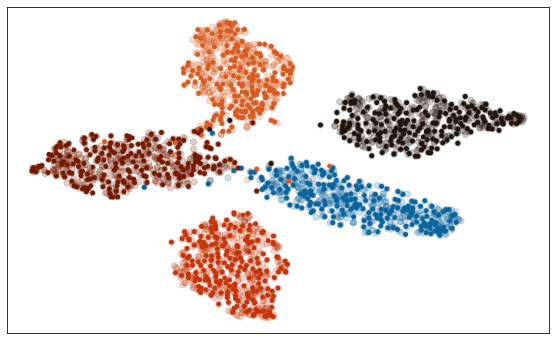

distances:  [0.01674223 0.08277334 0.02564118 0.01238536 0.06182353]
accuracy on training set: 93.97999999999999
accuracy on test set: 82.8
--------------------------------------------------------------------------------
20



True
True
torch.Size([100, 3, 32, 32])
torch.float32
---start new mnemonics updating---


epoch loss 01: 2.543
epoch loss 02: 1.954
epoch loss 03: 1.775
epoch loss 04: 1.687
epoch loss 05: 1.630
epoch loss 06: 1.586
epoch loss 07: 1.555
epoch loss 08: 1.549
epoch loss 09: 1.523
epoch loss 10: 1.496
epoch loss 11: 1.488
epoch loss 12: 1.475
epoch loss 13: 1.477
epoch loss 14: 1.469
epoch loss 15: 1.447
epoch loss 16: 1.445
epoch loss 17: 1.449
epoch loss 18: 1.435
epoch loss 19: 1.435
epoch loss 20: 1.421

distances:  [0.03340918 0.09195823 0.02915568 0.02258939 0.0683067 ]
accuracy on training set: 37.871428571428574
accuracy on test set: 47.449999999999996
--------------------------------------------------------------------------------
30



True
True
torch.Size([66, 3, 32, 32])
torch.float32
---start new mnemonics updating---


epoch loss 01: 1.622
epoch loss 02: 1.563
epoch loss 03: 1.545
epoch loss 04: 1.520
epoch loss 05: 1.509
epoch loss 06: 1.494
epoch loss 07: 1.489
epoch loss 08: 1.476
epoch loss 09: 1.476
epoch loss 10: 1.463
epoch loss 11: 1.460
epoch loss 12: 1.466
epoch loss 13: 1.465
epoch loss 14: 1.449
epoch loss 15: 1.450
epoch loss 16: 1.436
epoch loss 17: 1.442
epoch loss 18: 1.447
epoch loss 19: 1.439
epoch loss 20: 1.441

distances:  [0.03730334 0.11014895 0.02947918 0.0240484  0.06559051]
accuracy on training set: 22.7
accuracy on test set: 34.06666666666667
--------------------------------------------------------------------------------
40



True
True
torch.Size([50, 3, 32, 32])
torch.float32
---start new mnemonics updating---


epoch loss 01: 2.072
epoch loss 02: 2.068
epoch loss 03: 2.065
epoch loss 04: 2.062
epoch loss 05: 2.058
epoch loss 06: 2.052
epoch loss 07: 2.049
epoch loss 08: 2.045
epoch loss 09: 2.043
epoch loss 10: 2.039
epoch loss 11: 2.036
epoch loss 12: 2.033
epoch loss 13: 2.030
epoch loss 14: 2.028
epoch loss 15: 2.023
epoch loss 16: 2.021
epoch loss 17: 2.019
epoch loss 18: 2.014
epoch loss 19: 2.014
epoch loss 20: 2.012

distances:  [0.03459836 0.12281077 0.03226915 0.0389653  0.05861498]
accuracy on training set: 11.66189111747851
accuracy on test set: 26.200000000000003
--------------------------------------------------------------------------------
50



True
True
torch.Size([40, 3, 32, 32])
torch.float32
---start new mnemonics updating---


epoch loss 01: 2.231
epoch loss 02: 2.230
epoch loss 03: 2.229
epoch loss 04: 2.229
epoch loss 05: 2.228
epoch loss 06: 2.226
epoch loss 07: 2.226
epoch loss 08: 2.225
epoch loss 09: 2.224
epoch loss 10: 2.224
epoch loss 11: 2.223
epoch loss 12: 2.222
epoch loss 13: 2.221
epoch loss 14: 2.221
epoch loss 15: 2.219
epoch loss 16: 2.219
epoch loss 17: 2.218
epoch loss 18: 2.217
epoch loss 19: 2.217
epoch loss 20: 2.216



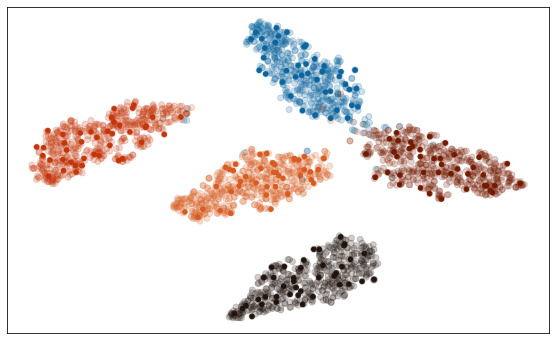

distances:  [0.04292814 0.09627439 0.02924159 0.0410509  0.05719408]
accuracy on training set: 8.371428571428572
accuracy on test set: 21.82
--------------------------------------------------------------------------------
60


KeyboardInterrupt: ignored

In [6]:
method = mnemonics(randomseed=203, name='mnemonics')
method.trainer()

In [ ]:
import pickle
with open("iCaRL_203_testacc", 'rb') as file:
  accuracy = pickle.load(file)
print(accuracy)

In [ ]:



a = torch.tensor([2., 3.])
print(a.requires_grad)
print(a.is_leaf)
mne = nn.ParameterList([nn.Parameter(a)])
b = torch.tensor([6., 4.], requires_grad=True)
Q = 3*mne[0]**3 - b**2
external_grad = torch.tensor([1., 1.])
Q.sum().backward()
mne[0].grad